<a href="https://colab.research.google.com/github/neeraj-singh04/Deep-Learning/blob/master/Titanic_survivor_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import required libraries and the dataset

In [0]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from statistics import mean
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import random
from matplotlib import rcParams
%matplotlib inline
le = preprocessing.LabelEncoder()
import re

In [0]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [0]:
# Appending test data with train data, since both dataset can have related values like family name and ticket
df = data.append(test, sort=False)

# Visualise a sample of dataset

In [68]:
# Creating a TicketId feature, it will tell which person was part of that Family or group
ticketNum = pd.DataFrame(df.Ticket.value_counts())
ticketNum.rename(columns = {'Ticket' : 'TicketNum'}, inplace = True)
ticketNum['TicketId'] = pd.Categorical(ticketNum.index).codes
ticketNum.loc[ticketNum.TicketNum < 3, 'TicketId'] = -1
df = pd.merge(left = df, right = ticketNum, left_on = 'Ticket', 
              right_index = True, how = 'left', sort = False)
df = df.drop(['TicketNum'],axis=1)
df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TicketId
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,-1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,-1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,-1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,-1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,-1


# Data preprocessing

In [0]:
# Separating FamilyName
  df['FamilyName'] = df.Name.apply(lambda x : str.split(x, ',')[0])

In [0]:
def CabinNum(data):
    data.Cabin = data.Cabin.fillna('0')
    regex = re.compile('\s*(\w+)\s*')
    data['CabinNum'] = data.Cabin.apply(lambda x : len(regex.findall(x)))
CabinNum(df)

In [71]:
df.CabinNum.value_counts()

1    1268
2      26
3      10
4       5
Name: CabinNum, dtype: int64

In [0]:
# Creating Feature Title, since Higher Rank people has more survival chances, should give hit and trail
def TitleFunc(data):
    sub = {'Col.','Rev.', 'Mr.','Sir.','Jonkheer.', 'Don.','Dona.','Capt.',
           'General.','Major.'}
    sub1 = {'Miss.','Mme.','Mlle.','Ms.'}
    sub2 = {'Mrs.','Countess.','Lady.'}
    sub3 = {'Master.'}
    sub4 = {'Dr.'}
    pattern, pattern1, pattern2, pattern3 = '|'.join(sub), '|'.join(sub1), '|'.join(sub2), '|'.join(sub3)
    pattern4 = '|'.join(sub4)
    data['Title'] = ''
    data.loc[data['Name'].str.contains(pattern),'Title'] = 'Mr.'
    data.loc[data['Name'].str.contains(pattern1),'Title'] = 'Miss.'
    data.loc[data['Name'].str.contains(pattern2),'Title'] = 'Mrs.'
    data.loc[data['Name'].str.contains(pattern3),'Title'] = 'Master.'
    data.loc[(data['Name'].str.contains(pattern)) & (data['Age'] <=13),'Title'] = 'Master.'
    data.loc[(data['Name'].str.contains(pattern4)) & (data['Sex'] == 'female'),'Title'] = 'Dr.f'
    data.loc[(data['Name'].str.contains(pattern4)) & (data['Sex'] == 'male'),'Title'] = 'Dr.m'
TitleFunc(df)


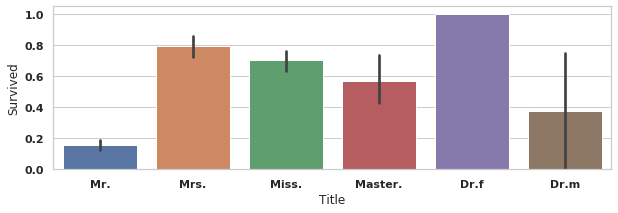

In [73]:
#Lets see Who Survived most
train1 = df[0:891].copy()
sns.set(style="whitegrid")
plt.figure(figsize=(10,3))
ax = sns.barplot(x="Title", y="Survived", data=train1)
#ax = sns.barplot(x="Title", y="Survived",hue='Title', data=train1)

In [74]:
# Lets first check missing fare
df.loc[df['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TicketId,FamilyName,CabinNum,Title
152,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,0,S,-1,Storey,1,Mr.


In [75]:
#Let's find simlar data, and fill that for missing fare
df.loc[(df['Age'] >= 60) & (df['Pclass'] ==3) & (df['Sex'] == 'male') & (df['Embarked'] =='S')]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TicketId,FamilyName,CabinNum,Title
326,327,0.0,3,"Nysveen, Mr. Johan Hansen",male,61.0,0,0,345364,6.2375,0,S,-1,Nysveen,1,Mr.
851,852,0.0,3,"Svensson, Mr. Johan",male,74.0,0,0,347060,7.7750,0,S,-1,Svensson,1,Mr.
152,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,0,S,-1,Storey,1,Mr.


In [0]:
# Creating FareCat Title, since High Fare people has more survival chances
def FareFunc(data):
    data.loc[data['Fare'].isnull(), 'Fare'] = 7            #First fill missing fare by least value
    data['FareCat'] = 0
    data.loc[data['Fare'] < 8, 'FareCat'] = 0
    data.loc[(data['Fare'] >= 8 ) & (data['Fare'] < 16),'FareCat' ] = 1
    data.loc[(data['Fare'] >= 16) & (data['Fare'] < 30),'FareCat' ] = 2
    data.loc[(data['Fare'] >= 30) & (data['Fare'] < 45),'FareCat' ] = 3
    data.loc[(data['Fare'] >= 45) & (data['Fare'] < 80),'FareCat' ] = 4
    data.loc[(data['Fare'] >= 80) & (data['Fare'] < 160),'FareCat' ] = 5
    data.loc[(data['Fare'] >= 160) & (data['Fare'] < 270),'FareCat' ] = 6
    data.loc[(data['Fare'] >= 270), 'FareCat'] = 7
FareFunc(df)

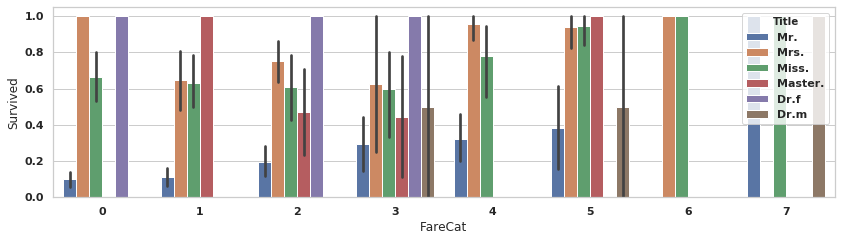

In [77]:
#Lets check which Fare class Survived along with their title
train1 = df[0:891].copy()
sns.set(style="whitegrid")
plt.figure(figsize=(14,3.5))
ax = sns.barplot(x="FareCat", y="Survived",hue='Title', data=train1)

In [0]:
# Creating FamlSize Feature, since Very big family dint survive as per data
def FamlSize(data):
    data['FamlSize'] = 0
    data['FamlSize'] = data['SibSp'] + data['Parch'] + 1
def IsAlone(data):
    data['IsAlone'] = 0
    data.loc[(data['FamlSize'] == 1), 'IsAlone'] = 0
    data.loc[(data['FamlSize'] > 1), 'IsAlone'] = 1
FamlSize(df)
IsAlone(df)

In [79]:
df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TicketId,FamilyName,CabinNum,Title,FareCat,FamlSize,IsAlone
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,S,-1,Braund,1,Mr.,0,2,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,-1,Cumings,1,Mrs.,4,2,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,S,-1,Heikkinen,1,Miss.,0,1,0


In [0]:
def LablFunc(data):
    lsr = {'Title','Cabin'}
    for i in lsr:
        le.fit(data[i].astype(str))
        data[i] = le.transform(data[i].astype(str))
LablFunc(df)

In [0]:
# Fill missing Age
## Lets predict the age of a person and fill the missing Age
features = ['Pclass','SibSp','Parch','TicketId','Fare','CabinNum','Title']
from sklearn.ensemble import ExtraTreesRegressor as ETRg
def AgeFunc(df):
    Etr = ETRg(n_estimators = 200, random_state = 2)
    AgeX_Train = df[features][df.Age.notnull()]
    AgeY_Train = df['Age'][df.Age.notnull()]
    AgeX_Test = df[features][df.Age.isnull()]
    
    Etr.fit(AgeX_Train,np.ravel(AgeY_Train))
    AgePred = Etr.predict(AgeX_Test)
    df.loc[df.Age.isnull(), 'Age'] = AgePred
    
AgeFunc(df)

In [0]:
# Lets derive AgeGroup feature from age
def AgeCat(data):
    data['AgeCat'] = 0
    data.loc[(data['Age'] <= 5), 'AgeCat'] = 0
    data.loc[(data['Age'] <= 12) & (data['Age'] > 5), 'AgeCat'] = 1
    data.loc[(data['Age'] <= 18) & (data['Age'] > 12), 'AgeCat'] = 2
    data.loc[(data['Age'] <= 22) & (data['Age'] > 18), 'AgeCat'] = 3
    data.loc[(data['Age'] <= 32) & (data['Age'] > 22), 'AgeCat'] = 4
    data.loc[(data['Age'] <= 45) & (data['Age'] > 32), 'AgeCat'] = 5
    data.loc[(data['Age'] <= 60) & (data['Age'] > 45), 'AgeCat'] = 6
    data.loc[(data['Age'] <= 70) & (data['Age'] > 60), 'AgeCat'] = 7
    data.loc[(data['Age'] > 70), 'AgeCat'] = 8
AgeCat(df)

In [0]:
#Lets check which Fare class Survived along with their title
train1 = df[0:891].copy()
sns.set(style="whitegrid")
plt.figure(figsize=(14,3.5))
ax = sns.barplot(x="AgeCat", y="Survived",hue='Sex', data=train1)

In [0]:
def AgeCatTitle(data):
    data['AgeCatTitle'] = data['Title'].map(str) + data['AgeCat'].map(str)
#AgeCatTitle(df)

In [84]:
df.loc[df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TicketId,FamilyName,CabinNum,Title,FareCat,FamlSize,IsAlone,AgeCat
61,62,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,31,NaN,-1,Icard,1,3,5,1,0,5
829,830,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,31,NaN,-1,Stone,1,5,5,1,0,7


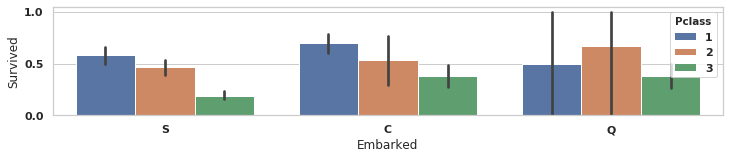

In [85]:
#Lets Check first from where 1st Class passesnger Came
sns.set(style="whitegrid")
plt.figure(figsize=(12,2))
ax = sns.barplot(x="Embarked", y="Survived",hue='Pclass', data=df)

In [0]:
# from 'C' high number of 1st Pclass people Survived, lets fill 'C' in missing value
def FillEmbk(data):
    var = 'Embarked'
    data.loc[(data.Embarked.isnull()),'Embarked']= 'C'
FillEmbk(df)

In [0]:
# Label Encode Embarked
def LablFunc(data):
    lst = {'Embarked','Sex'}
    for i in lst:
        le.fit(data[i].astype(str))
        data[i] = le.transform(data[i].astype(str))
LablFunc(df)

In [88]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'TicketId',
       'FamilyName', 'CabinNum', 'Title', 'FareCat', 'FamlSize', 'IsAlone',
       'AgeCat'],
      dtype='object')

In [89]:
# Lets Scale the data now
from sklearn.preprocessing import StandardScaler
target = data['Survived'].values
select_features = ['Pclass', 'Age','AgeCat','SibSp', 'Parch', 'Fare', 
                   'Embarked', 'TicketId', 'CabinNum', 'Title','Cabin',
                   'FareCat', 'FamlSize','Sex']
scaler = StandardScaler()
dfScaled = scaler.fit_transform(df[select_features])
train = dfScaled[0:891].copy()
test = dfScaled[891:].copy()
test.shape

(418, 14)

In [90]:
# Checking best features
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, len(select_features))
selector.fit(train, target)
scores = -np.log10(selector.pvalues_)
indices = np.argsort(scores)[::-1]

print('Features importance:')
for i in range(len(scores)):
    print('%.2f %s' % (scores[indices[i]], select_features[indices[i]]))

Features importance:
68.85 Sex
24.60 Pclass
22.30 FareCat
16.54 Cabin
14.21 Fare
6.78 Embarked
2.07 AgeCat
1.83 Parch
1.81 Title
1.52 CabinNum
1.48 Age
1.07 TicketId
0.53 SibSp
0.21 FamlSize


In [0]:
# Define Feture importance function
def FeatFunc(t_data,model):
    names = t_data.columns.values
    print("Features sorted by their score:")
    print(sorted(zip(map(lambda x: round(x, 4), model.feature_importances_), names), 
                 reverse=True))

In [92]:
train.shape

(891, 14)

# Sequential Model Building with Activation for each layer

In [0]:
from keras import models, regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
import numpy
numpy.random.seed(7)
model = models.Sequential()
model.add(Dense(64,input_dim=14,activation='relu'))  # Adding input layer of 30 Neurons and 15 inputs
model.add(Dropout(0.25))                              # Adding droupout layer to overcome overfitting
model.add(Dense(64,activation='relu'))               # Adding 1 hidden layer of 15 Neurons
model.add(Dropout(0.25))                              # Adding droupout layer to overcome overfitting
model.add(Dense(32,activation='relu'))                # Adding 1 hidden layer of 3 Neurons
model.add(Dropout(0.25))                              # Adding droupout layer to overcome overfitting
model.add(Dense(1,activation='sigmoid'))             # Output layer of 1 neuron of sigmoid type

# Compile with binary CE loss and metric accuracy

In [0]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Train Model with cross validation, with total time taken shown for 20 epochs

In [45]:
history = model.fit(train,target,epochs=20, batch_size=10, verbose=1,validation_split=0.2)




Train on 712 samples, validate on 179 samples
Epoch 1/20





712/712 [==============================] - 10s 14ms/step - loss: 0.6250 - acc: 0.6545 - val_loss: 0.4629 - val_acc: 0.8324
Epoch 2/20
712/712 [==============================] - 0s 578us/step - loss: 0.5257 - acc: 0.7444 - val_loss: 0.3944 - val_acc: 0.8492
Epoch 3/20
712/712 [==============================] - 0s 519us/step - loss: 0.4854 - acc: 0.7865 - val_loss: 0.3685 - val_acc: 0.8324
Epoch 4/20
712/712 [==============================] - 0s 581us/step - loss: 0.4670 - acc: 0.7767 - val_loss: 0.3716 - val_acc: 0.8380
Epoch 5/20
712/712 [==============================] - 0s 549us/step - loss: 0.4630 - acc: 0.7992 - val_loss: 0.3622 - val_acc: 0.8436
Epoch 6/20
712/712 [==============================] - 0s 434us/step - loss: 0.4498 - acc: 0.8020 - val_loss: 0.3672 - val_acc: 0.8380
Epoch 7/20
712/712 [==============================] - 0s 593us/step - loss: 0.4289 - acc: 0.8188 - val_loss: 0.3556 - val_acc: 0.8492
Epoch 8/

# Visualise Loss and Accuracy history 

In [46]:
history.history

{'acc': [0.6544943827340443,
  0.744382022220767,
  0.7865168499142936,
  0.7766853927561407,
  0.7991572981804944,
  0.8019662887862559,
  0.8188202191939514,
  0.7949438198898615,
  0.8258426906017775,
  0.806179772936896,
  0.8019662917999739,
  0.813202243256435,
  0.8258426936154954,
  0.8356741516107924,
  0.8370786454905285,
  0.824438194712896,
  0.827247185402372,
  0.8244381997357594,
  0.8244381968057557,
  0.816011233108767],
 'loss': [0.6250362171048529,
  0.5256729382142592,
  0.4854418198379238,
  0.46701184877853713,
  0.4629694969299134,
  0.4497803659753853,
  0.428867373113217,
  0.44769540956515946,
  0.4320574106878779,
  0.43890667011898554,
  0.43521462087885715,
  0.4201194364368246,
  0.41863592328985083,
  0.4195182069382641,
  0.4018128894143895,
  0.40903476110837433,
  0.410555826248915,
  0.41938198872664,
  0.4154203221243754,
  0.3976289851988634],
 'val_acc': [0.832402222982332,
  0.8491620051794212,
  0.8324022279771347,
  0.8379888248177214,
  0.84357

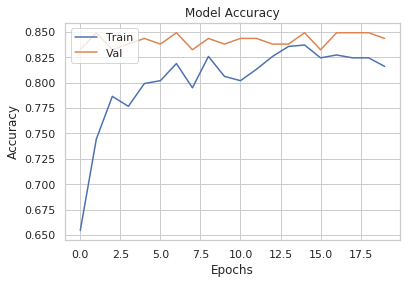

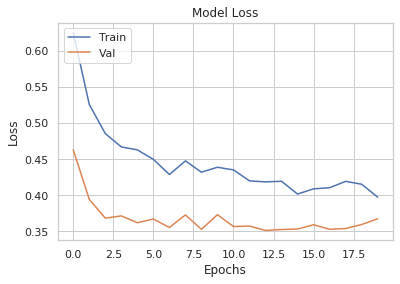

In [48]:

# Plot training & val accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train','Val'],loc='upper left')
plt.show()

# Plot training % val loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train','Val'],loc='upper left')
plt.show()

# Show Confusion Matrix for validation dataset

In [0]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import matplotlib

In [0]:
X_train = data.drop("Survived", axis=1)
Y_train = data["Survived"]

X_test  = df.drop("PassengerId", axis=1).copy()

In [0]:
from sklearn.metrics import accuracy_score

In [0]:
font = {
    'family':'Times New Roman',
    'weight':'bold',
    'size':16 
}
matplotlib.rc('font',**font)
mat = confusion_matrix(y_test, history)
plot_confusion_matrix(conf_mat=mat,figsize=(8,8),class_names=class_names,show_normed=True)